# Client Churn Prediction
### CRISP-DM Cycle 4
---
The Top Bank company operates in Europe with a bank account as the main product, this product can keep client's salary and make payments. This account doesn't have any cost in the first 12 months, however, after that time trial, the client needs to rehire the bank for upcoming 12 months and redo this process every year. Recently the Analytics Team noticed that the churn rate is increasing.

As a Data Science Consultant, you need to create an action plan to decrease the number of churn customers and show the financial return on your solution.
At the end of your consultancy, you need to deliver to the TopBottom CEO a model in production, which will receive a customer base via API and return that same base with an extra column with the probability of each customer going into churn.
In addition, you will need to provide a report reporting your model's performance and the financial impact of your solution. Questions that the CEO and the Analytics team would like to see in their report:

1.  What is Top Bank's current Churn rate?
2.  How does the churn rate vary monthly?
3.  What is the performance of the model in classifying customers as churns
4.  What is the expected return, in terms of revenue, if the company uses its model to avoid churn from customers?

> Disclaimer: This is a fictional business case

## 0. Preparation

### 0.1 Planning

#### Input

- Predict whether customer will be in churn;
- Dataset with sales records and customers info.

#### Output

- Which customer will be in churn;
- Churn rate of the company;
- Performance of the model;
- Action plan


#### Tasks

1. Which customer will be in churn:
    - What is the criterion?
        - Downtime
        - Time remaining until the contract ends


1. Current churn rate of the company:
    - Calculate churn rate
    - Calculate monthly churn rate and variation

2. Performance of the model:
Metrics:
    - Precision at K score
    - Recall at K score

3. Action plan:
    - Discount?
    - Voucher?
    - Deposit bonus?

### 0.2 Imports & Settings

In [1]:
import polars as pl
from matplotlib import pyplot as plt
import seaborn as sns
from IPython.core.display import HTML
import duckdb
from pathlib import Path


from src.utils_data_description import (
    DataDescription,
    plot_features,
    categorical_metrics,
)
from src.utils_feature_engineering import FeatureEngineering

In [2]:
def jupyter_settings():
    """
    Plots pre settings.
    """

    %matplotlib inline
    plt.style.use("seaborn-v0_8-whitegrid")
    plt.rcParams["figure.figsize"] = [25, 12]
    plt.rcParams["font.size"] = 24
    display(HTML("<style>.container {width:100% !important;}</style>"))
    sns.set()


jupyter_settings()

seed = 42

### 0.3 Path

In [3]:
# found the main project folders
path = Path().resolve().parent
data_path = path / "data"
fig_path = path / "pics"
reports_path = path / "reports"

### 0.4 Data

This dataset is available [here](https://www.kaggle.com/mervetorkan/churndataset).


**Data fields**

- **RowNumber**: the number of the columns
- **CustomerID**: unique identifier of clients
- **Surname**: client's last name
- **CreditScore**: clients credit score for the financial market
- **Geography**: the country of the client
- **Gender**: the gender of the client
- **Age**: the client's age
- **Tenure**: number of years the client is in the bank 
- **Balance**: the amount that the client has in their account 
- **NumOfProducts**: the number of products that the client bought 
- **HasCrCard**: if the client has a credit card 
- **IsActiveMember**: if the client is active (within the last 12 months) 
- **EstimateSalary**: estimate of annual salary of clients 
- **Exited**: if the client is a churn (*target variable*)

In [4]:
# Load data in duckdb
conn_path = str(data_path / "interim/churn.db")
conn = duckdb.connect(database=conn_path, read_only=False)
query = conn.execute("SELECT * FROM churn")
df = pl.DataFrame(query.fetchdf())
conn.close()

## 1. Data Description

In [5]:
# class instance
dd = DataDescription(df)

dd.show_data()

row_number,customer_id,surname,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
i64,i64,str,i64,str,str,i64,i64,f64,i64,i64,i64,f64,i64
1,15634602,"""Hargrave""",619,"""France""","""Female""",42,2,0.0,1,1,1,101348.88,1
2,15647311,"""Hill""",608,"""Spain""","""Female""",41,1,83807.86,1,0,1,112542.58,0
3,15619304,"""Onio""",502,"""France""","""Female""",42,8,159660.8,3,1,0,113931.57,1
4,15701354,"""Boni""",699,"""France""","""Female""",39,1,0.0,2,0,0,93826.63,0
5,15737888,"""Mitchell""",850,"""Spain""","""Female""",43,2,125510.82,1,1,1,79084.1,0


### 1.1 Data Dimensions

In [6]:
dd.data_dimensions()

Number of Rows: 10000
Number of Columns: 14


### 1.2 Data Types

In [7]:
dd.data_types()

{'row_number': Int64,
 'customer_id': Int64,
 'surname': String,
 'credit_score': Int64,
 'geography': String,
 'gender': String,
 'age': Int64,
 'tenure': Int64,
 'balance': Float64,
 'num_of_products': Int64,
 'has_cr_card': Int64,
 'is_active_member': Int64,
 'estimated_salary': Float64,
 'exited': Int64}

Some features are categorical but has some encoding technique.
`is_active_member`, `exited` and `has_cr_card` should be strings.

In [8]:
df_col = df.with_columns(
    [
        pl.when(pl.col(col) == 1)
        .then(pl.lit("yes"))
        .otherwise(pl.lit("no"))
        .alias(col)  # lit is a literal value
        for col in ["is_active_member", "exited", "has_cr_card"]
    ]
)

In [9]:
dd = DataDescription(df_col)

### 1.3 Check NA

In [10]:
dd.check_na()

row_number,customer_id,surname,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,0,0,0,0,0,0,0,0,0,0,0


There's no NA in this dataset, however, there's a possibility that there are zeros in place of NAs.

In [11]:
df_verify = df_col.select(
    ["credit_score", "num_of_products", "estimated_salary", "balance", "age"]
)

# Verify if there are zeros in the dataset
df_verify = df_verify.with_columns(
    [
        pl.when(pl.col(col) != 0)
        .then(pl.lit("another_value"))
        .otherwise(pl.lit("zero"))
        .alias(col)
        for col in df_verify.columns
    ]
)

unique_values = df_verify.select(
    [pl.col(col).unique().alias(col) for col in df_verify.columns]
)
unique_values.transpose(include_header=True)

column,column_0,column_1
str,str,str
"""credit_score""","""another_value""","""another_value"""
"""num_of_products""","""another_value""","""another_value"""
"""estimated_salary""","""another_value""","""another_value"""
"""balance""","""zero""","""another_value"""
"""age""","""another_value""","""another_value"""


In [12]:
df_verify["balance"].value_counts()

balance,count
str,u32
"""another_value""",6383
"""zero""",3617


The balance columns has more than 1/3 of zero values, it doesn't mean that they're missing values but the DS team should get more information about this.

### 1.4 Descriptive Statistics

#### 1.4.1 Numerical Features

In [13]:
num_features = dd.select_numeric_features()
num_features = num_features.drop(["row_number", "customer_id"])
num_features.describe().transpose(include_header=True)

column,column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8
str,str,str,str,str,str,str,str,str,str
"""statistic""","""count""","""null_count""","""mean""","""std""","""min""","""25%""","""50%""","""75%""","""max"""
"""credit_score""","""10000.0""","""0.0""","""650.5288""","""96.65329873613035""","""350.0""","""584.0""","""652.0""","""718.0""","""850.0"""
"""age""","""10000.0""","""0.0""","""38.9218""","""10.487806451704609""","""18.0""","""32.0""","""37.0""","""44.0""","""92.0"""
"""tenure""","""10000.0""","""0.0""","""5.0128""","""2.8921743770496837""","""0.0""","""3.0""","""5.0""","""7.0""","""10.0"""
"""balance""","""10000.0""","""0.0""","""76485.889288""","""62397.405202385955""","""0.0""","""0.0""","""97208.46""","""127642.44""","""250898.09"""
"""num_of_products""","""10000.0""","""0.0""","""1.5302""","""0.5816543579989906""","""1.0""","""1.0""","""1.0""","""2.0""","""4.0"""
"""estimated_salary""","""10000.0""","""0.0""","""100090.23988099999""","""57510.49281769816""","""11.58""","""51011.29""","""100200.4""","""149384.43""","""199992.48"""


In [14]:
num_features_pandas = num_features.to_pandas()

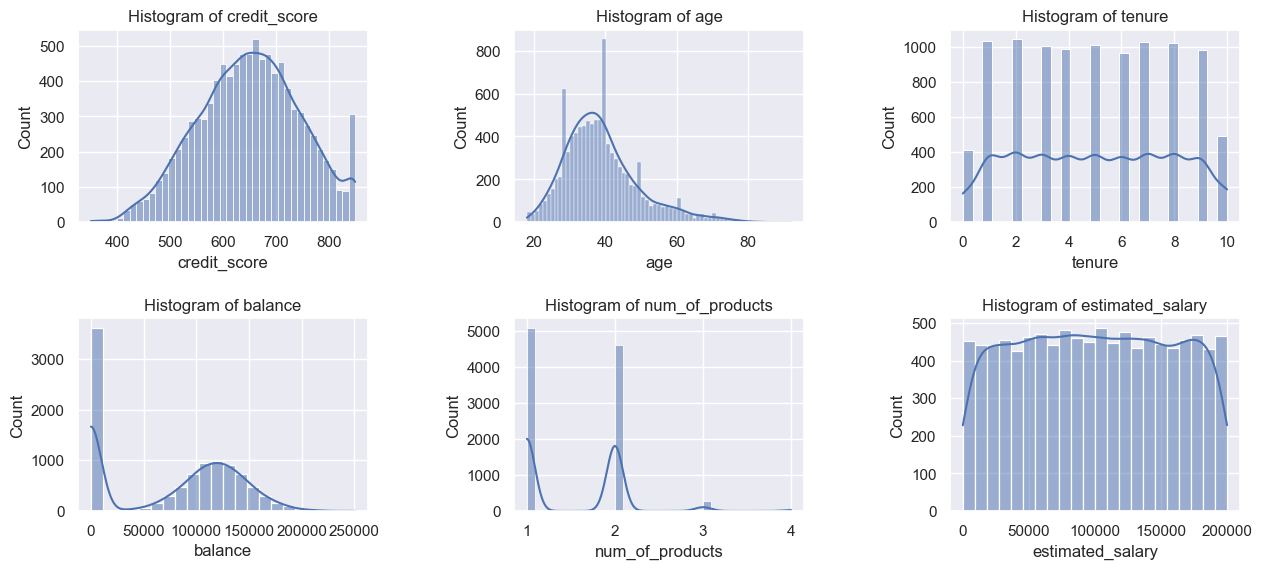

In [15]:
plot_features(num_features_pandas, plot_type="histplot")

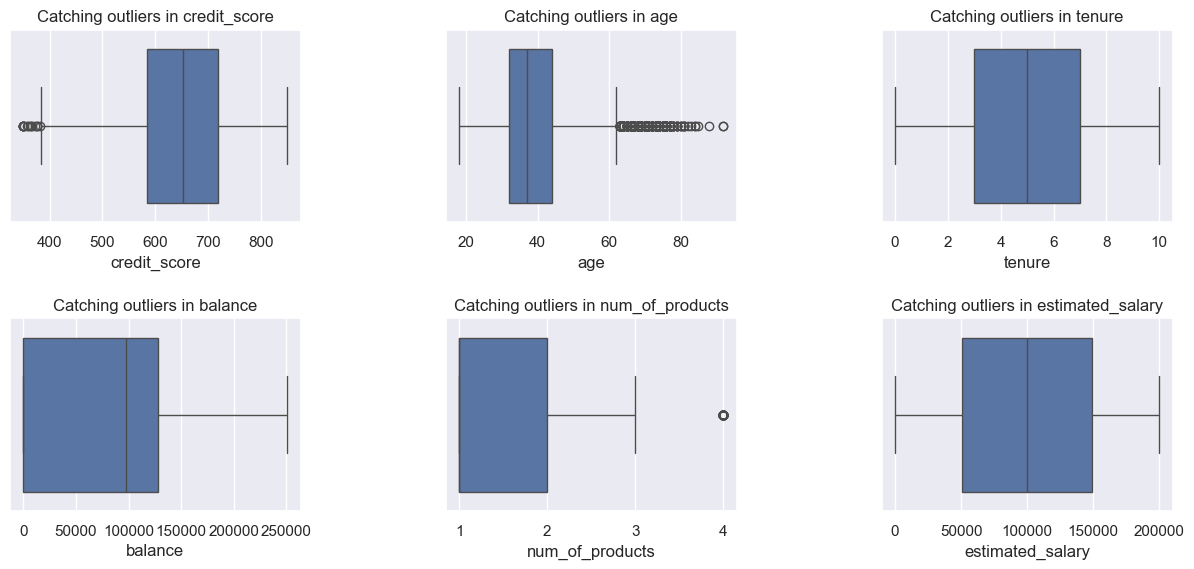

In [16]:
plot_features(num_features_pandas, plot_type="boxplot")

Negative outliers in `credit_score` and positive outliers in `num_of_products` and `age`

#### 1.4.2 Categorical Features

In [17]:
cat_features = dd.select_categorical_features()
cat_features = cat_features.to_pandas()

In [18]:
categorical_metrics(cat_features, "is_active_member")

,absolute,percent %
is_active_member,,
yes,5151,51.51
no,4849,48.49


In [19]:
categorical_metrics(cat_features, "has_cr_card")

,absolute,percent %
has_cr_card,,
yes,7055,70.55
no,2945,29.45


In [20]:
categorical_metrics(cat_features, "exited")

,absolute,percent %
exited,,
no,7963,79.63
yes,2037,20.37


In [21]:
categorical_metrics(cat_features, "geography")

,absolute,percent %
geography,,
France,5014,50.14
Germany,2509,25.09
Spain,2477,24.77


In [22]:
categorical_metrics(cat_features, "gender")

,absolute,percent %
gender,,
Male,5457,54.57
Female,4543,45.43


Important information:
- There are outliers in **credit_score, num_of_products and age**
- The **churn ratio is 20.37%**;
- **70.6%** of the members **has credit card**;
- More than **50% of the clients** are **from France**

## 2. Feature Engineering

### 2.1 Create Features

In [23]:
df = df.to_pandas()

fe = FeatureEngineering(seed=seed)
X_train, X_test, X_val, y_train, y_test, y_val, id_train, id_test, id_val = (
    fe.transform(df)
)

### 2.2 Check NA

In [24]:
fe.report_na(X_train)

INFO - There are no NA values in any column.


In [25]:
fe.report_na(X_test)

INFO - There are no NA values in any column.


In [26]:
fe.report_na(X_val)

INFO - There are no NA values in any column.


### 2.3 Comparing Train, Test and Validation

In [27]:
reports_path = str(reports_path)
fe.get_comparative_reports(
    X_train, X_test, (reports_path + "/comp_report_train_test.html")
)
fe.get_comparative_reports(
    X_train, X_val, (reports_path + "/comp_report_train_val.html")
)
fe.get_comparative_reports(X_test, X_val, (reports_path + "/comp_report_test_val.html"))

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

WARNING - File already exists. It will be overwritten.


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

INFO - Comparison report saved.


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

WARNING - File already exists. It will be overwritten.


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

INFO - Comparison report saved.


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

WARNING - File already exists. It will be overwritten.


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

INFO - Comparison report saved.


In [28]:
data_path = str(data_path / "processed")
fe.save_data(X_train, (data_path + "/X_train.parquet"))
fe.save_data(X_test, (data_path + "/X_test.parquet"))
fe.save_data(X_val, (data_path + "/X_val.parquet"))
fe.save_data(y_train, (data_path + "/y_train.pkl"))
fe.save_data(y_test, (data_path + "/y_test.pkl"))
fe.save_data(y_val, (data_path + "/y_val.pkl"))

WARNING - File already exists. It will be overwritten.
INFO - Dataframe successfully saved as /Users/gutto/Repos/churn-ticket/data/processed/X_train.parquet
WARNING - File already exists. It will be overwritten.
INFO - Dataframe successfully saved as /Users/gutto/Repos/churn-ticket/data/processed/X_test.parquet
WARNING - File already exists. It will be overwritten.
INFO - Dataframe successfully saved as /Users/gutto/Repos/churn-ticket/data/processed/X_val.parquet
WARNING - File already exists. It will be overwritten.
INFO - Series successfully saved as /Users/gutto/Repos/churn-ticket/data/processed/y_train.pkl
WARNING - File already exists. It will be overwritten.
INFO - Series successfully saved as /Users/gutto/Repos/churn-ticket/data/processed/y_test.pkl
WARNING - File already exists. It will be overwritten.
INFO - Series successfully saved as /Users/gutto/Repos/churn-ticket/data/processed/y_val.pkl
